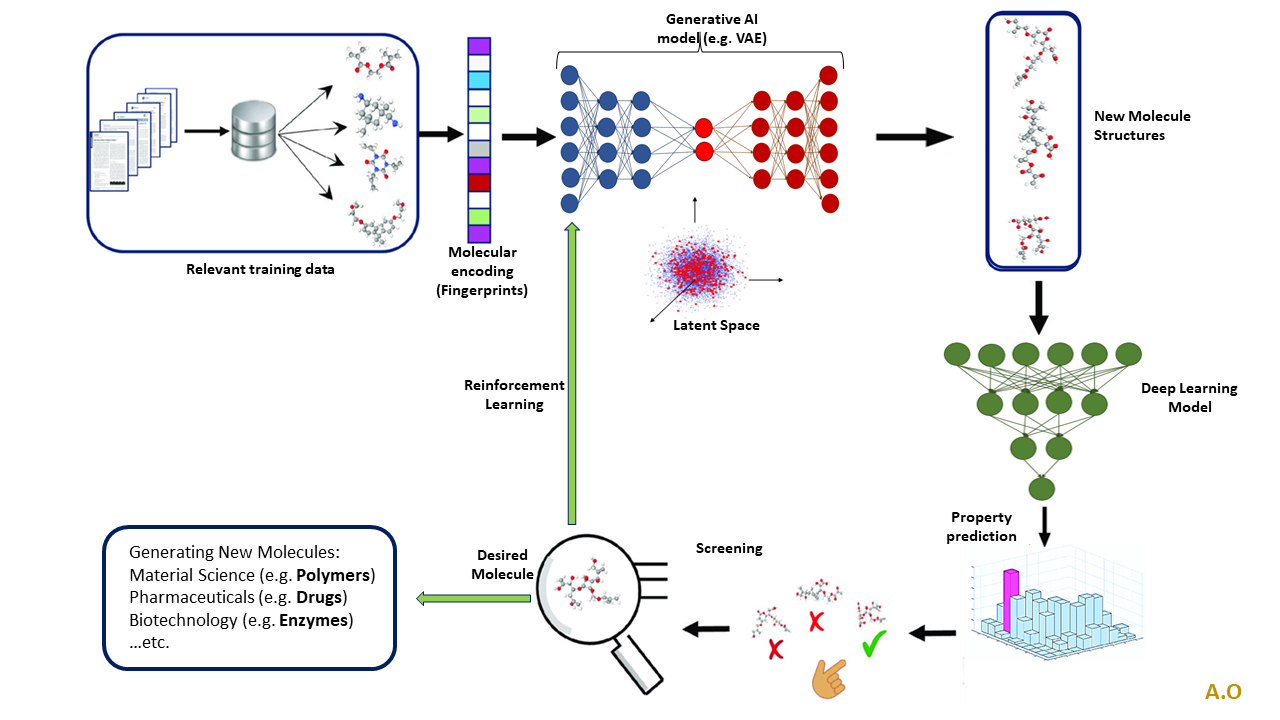

In [1]:
from IPython.display import Image
Image(filename='../models/workflow.png')

In [95]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Import your custom functions and classes from the vae_module.py
from src.vae_module import flatten
from src.vae_module import VAE
from src.vae_module import train_vae

import selfies as sf
import numpy as np
import pandas as pd
import sys

sys.path.append('../')

data = pd.read_csv('../data/test.csv', header=None, names=['smiles', 'property'])
data.head()

,smiles,property
0,CCCCCCCCC(O)CO,3.361728
1,CCCCCCCCC(O)CCO,3.361728
2,CCCCCCCCCCCCC(O)CCO,1.113943
3,CCCCCCCCOCCO,3.690196
4,CCCCCCCCOCCOCCOCCO,3.875061


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Import your custom functions and classes from the vae_module.py
from src.vae_module import flatten
from src.vae_module import VAE
from src.vae_module import train_vae

import selfies as sf
import numpy as np
import pandas as pd
import sys

sys.path.append('../')

data = pd.read_csv('../data/test.csv', header=None, names=['smiles', 'property'])
data.head()

In [41]:
input_smiles_list = data.iloc[:, 0].tolist()
input_selfies_list = list(map(sf.encoder, input_smiles_list))

# Parameters for encoding
max_len = max(sf.len_selfies(s) for s in input_selfies_list)
alphabet = sf.get_alphabet_from_selfies(input_selfies_list)
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))
vocab_stoi = {symbol: idx for idx, symbol in enumerate(alphabet)}
vocab_itos = {idx: symbol for symbol, idx in vocab_stoi.items()}

# Convert SELFIES to one-hot encoding
input_one_hot_arr = np.array([sf.selfies_to_encoding(s, vocab_stoi, pad_to_len=max_len)[1] for s in input_selfies_list])
input_one_hot_arr

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [42]:
## Convert the "input_one_hot_arr" dataset to tensor
x_train = torch.tensor(input_one_hot_arr, dtype=torch.float32)
x_train

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0., 

In [43]:
# Flatten the input data using the custom 'flatten' function
# This function takes a 3D tensor 'x_train' and reshapes it into a 2D tensor
width, height, input_dim, flattened_dataset = flatten(x_train)

# Define hyperparameters
batch_size = 64  # Batch size for training
latent_dim = 32  # Dimensionality of the latent space
num_epochs = 500  # Number of training epochs

# Create a PyTorch dataset and data loader for training
train_dataset = TensorDataset(flattened_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a VAE model instance
vae = VAE(input_dim, latent_dim)

#Define the optimizer for training the VAE model
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Train the VAE model using the 'train_vae' function
train_vae(vae, train_loader, optimizer, num_epochs)

Epoch [1/500], Loss: 27823.833984375
Epoch [2/500], Loss: 24637.181640625
Epoch [3/500], Loss: 21212.6474609375
Epoch [4/500], Loss: 16453.0849609375
Epoch [5/500], Loss: 11281.099609375
Epoch [6/500], Loss: 7530.000732421875
Epoch [7/500], Loss: 6292.650390625
Epoch [8/500], Loss: 6268.41455078125
Epoch [9/500], Loss: 5695.01318359375
Epoch [10/500], Loss: 4795.84521484375
Epoch [11/500], Loss: 3962.36962890625
Epoch [12/500], Loss: 3390.5810546875
Epoch [13/500], Loss: 3234.49365234375
Epoch [14/500], Loss: 3136.9393310546875
Epoch [15/500], Loss: 3138.45361328125
Epoch [16/500], Loss: 2977.865966796875
Epoch [17/500], Loss: 2969.9644775390625
Epoch [18/500], Loss: 2709.37109375
Epoch [19/500], Loss: 2703.716552734375
Epoch [20/500], Loss: 2644.983154296875
Epoch [21/500], Loss: 2642.812255859375
Epoch [22/500], Loss: 2685.1297607421875
Epoch [23/500], Loss: 2624.2979736328125
Epoch [24/500], Loss: 2569.0682373046875
Epoch [25/500], Loss: 2506.9029541015625
Epoch [26/500], Loss: 2477

Epoch [207/500], Loss: 1670.7981567382812
Epoch [208/500], Loss: 1645.9940795898438
Epoch [209/500], Loss: 1631.1032104492188
Epoch [210/500], Loss: 1636.38037109375
Epoch [211/500], Loss: 1670.0582885742188
Epoch [212/500], Loss: 1607.5814208984375
Epoch [213/500], Loss: 1603.54833984375
Epoch [214/500], Loss: 1654.9095458984375
Epoch [215/500], Loss: 1650.9163208007812
Epoch [216/500], Loss: 1607.7830200195312
Epoch [217/500], Loss: 1621.3615112304688
Epoch [218/500], Loss: 1581.5601806640625
Epoch [219/500], Loss: 1605.317626953125
Epoch [220/500], Loss: 1598.707763671875
Epoch [221/500], Loss: 1591.2838745117188
Epoch [222/500], Loss: 1615.9169311523438
Epoch [223/500], Loss: 1628.0985717773438
Epoch [224/500], Loss: 1613.469482421875
Epoch [225/500], Loss: 1599.6575927734375
Epoch [226/500], Loss: 1606.3958129882812
Epoch [227/500], Loss: 1589.6065673828125
Epoch [228/500], Loss: 1603.3862915039062
Epoch [229/500], Loss: 1564.1543579101562
Epoch [230/500], Loss: 1556.3901977539062

Epoch [407/500], Loss: 1244.0680541992188
Epoch [408/500], Loss: 1270.8707275390625
Epoch [409/500], Loss: 1300.63330078125
Epoch [410/500], Loss: 1280.115478515625
Epoch [411/500], Loss: 1266.7872314453125
Epoch [412/500], Loss: 1299.3438110351562
Epoch [413/500], Loss: 1288.272216796875
Epoch [414/500], Loss: 1311.7827758789062
Epoch [415/500], Loss: 1336.99853515625
Epoch [416/500], Loss: 1321.020751953125
Epoch [417/500], Loss: 1292.6240234375
Epoch [418/500], Loss: 1309.8209838867188
Epoch [419/500], Loss: 1284.2820434570312
Epoch [420/500], Loss: 1274.59033203125
Epoch [421/500], Loss: 1302.9610595703125
Epoch [422/500], Loss: 1281.7442016601562
Epoch [423/500], Loss: 1288.224365234375
Epoch [424/500], Loss: 1259.2951049804688
Epoch [425/500], Loss: 1256.410400390625
Epoch [426/500], Loss: 1270.5681762695312
Epoch [427/500], Loss: 1312.7376098632812
Epoch [428/500], Loss: 1262.5934448242188
Epoch [429/500], Loss: 1247.8514404296875
Epoch [430/500], Loss: 1243.7272338867188
Epoch 

In [47]:
# Generate molecules from the trained VAE
vae.eval()
num_samples = 1  # generate a sample
with torch.no_grad():
    latent_samples = torch.randn(num_samples, latent_dim)
    generated_molecules = vae.decoder(latent_samples)

In [75]:
## This is the property model architecture
## Define your neural network model
class Prediction_Model(nn.Module):
    def __init__(self, input_dim):
        super(Prediction_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.LeakyReLU(0.05)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.LeakyReLU(0.05)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Creating an instance of the prediction model
prediction_model = Prediction_Model(input_dim)

# Load the saved prediction model's state dictionary
prediction_model.load_state_dict(torch.load('../models/prediction_model.pt'))
prediction_model.eval()  # Set the model in evaluation mode

## The output from the vae (generated_molecules) is a 2D tensor 
# Make predictions using the loaded model
with torch.no_grad():
    predicted_property = prediction_model(generated_molecules).item()
predicted_property

2.8819000720977783

In [76]:
### Reinforcement Learning

In [77]:
# Define a reward function
def calculate_reward(property_value):
    # Define the threshold for the property value
    threshold = 2.0
    
    # Calculate the reward
    if property_value > threshold:
        return 1.0  # Positive reward for good molecules (>3.0 property)
    else:
        return -1.0  # No reward for molecules with property <= 3.0

# Define hyperparameters for reinforcement learning
num_episodes = 2000  # Number of episodes for training
learning_rate = 0.01

# Define the optimizer for updating the VAE model
vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Reinforcement learning loop
for episode in range(num_episodes):
    # Generate a molecule using the VAE model
    vae.eval()
    with torch.no_grad():
        latent_sample = torch.randn(1, latent_dim)
        generated_molecule = vae.decoder(latent_sample)
    
    # Calculate the property of the generated molecule using the prediction model
    prediction_model.eval()
    with torch.no_grad():
        predicted_property = prediction_model(generated_molecule).item()
    
    # Calculate the reward based on the property value
    reward = calculate_reward(predicted_property)
    
    # Update the VAE model using reinforcement learning
    vae.train()
    vae_optimizer.zero_grad()
    
    # Forward pass: Get reconstruction, mean, and log variance
    recon_x, mu, log_var = vae(generated_molecule)
    
    # Calculate the VAE loss
    loss = vae.vae_loss(recon_x, generated_molecule, mu, log_var)
    
    # Add the reward term to the loss
    total_loss = loss - reward
    
    # Backpropagate and update the VAE model
    total_loss.backward()
    vae_optimizer.step()

    # Print episode information
    print(f"Episode {episode + 1}/{num_episodes}: Reward = {reward}, Property = {predicted_property}")

Episode 1/2000: Reward = -1.0, Property = 1.3642773628234863
Episode 2/2000: Reward = -1.0, Property = 1.3693946599960327
Episode 3/2000: Reward = -1.0, Property = 1.572376012802124
Episode 4/2000: Reward = -1.0, Property = 1.6361217498779297
Episode 5/2000: Reward = -1.0, Property = 1.9665541648864746
Episode 6/2000: Reward = 1.0, Property = 2.165541648864746
Episode 7/2000: Reward = 1.0, Property = 2.2910964488983154
Episode 8/2000: Reward = 1.0, Property = 2.723092555999756
Episode 9/2000: Reward = 1.0, Property = 3.8942558765411377
Episode 10/2000: Reward = 1.0, Property = 3.205810546875
Episode 11/2000: Reward = 1.0, Property = 2.351271152496338
Episode 12/2000: Reward = 1.0, Property = 3.469792366027832
Episode 13/2000: Reward = 1.0, Property = 3.4218428134918213
Episode 14/2000: Reward = 1.0, Property = 3.643735408782959
Episode 15/2000: Reward = 1.0, Property = 3.7397892475128174
Episode 16/2000: Reward = 1.0, Property = 3.513974189758301
Episode 17/2000: Reward = 1.0, Property

Episode 155/2000: Reward = 1.0, Property = 3.214580535888672
Episode 156/2000: Reward = 1.0, Property = 3.2157034873962402
Episode 157/2000: Reward = 1.0, Property = 3.215212345123291
Episode 158/2000: Reward = 1.0, Property = 3.2173378467559814
Episode 159/2000: Reward = 1.0, Property = 3.247028350830078
Episode 160/2000: Reward = 1.0, Property = 3.244302272796631
Episode 161/2000: Reward = 1.0, Property = 3.225280284881592
Episode 162/2000: Reward = 1.0, Property = 3.216048002243042
Episode 163/2000: Reward = 1.0, Property = 3.215653419494629
Episode 164/2000: Reward = 1.0, Property = 3.2154507637023926
Episode 165/2000: Reward = 1.0, Property = 3.2155280113220215
Episode 166/2000: Reward = 1.0, Property = 3.2156765460968018
Episode 167/2000: Reward = 1.0, Property = 3.2154431343078613
Episode 168/2000: Reward = 1.0, Property = 3.295423984527588
Episode 169/2000: Reward = 1.0, Property = 3.2172985076904297
Episode 170/2000: Reward = 1.0, Property = 3.215681552886963
Episode 171/2000:

Episode 309/2000: Reward = 1.0, Property = 3.221101999282837
Episode 310/2000: Reward = 1.0, Property = 3.2172048091888428
Episode 311/2000: Reward = 1.0, Property = 3.2038631439208984
Episode 312/2000: Reward = 1.0, Property = 3.2294631004333496
Episode 313/2000: Reward = 1.0, Property = 3.215952157974243
Episode 314/2000: Reward = 1.0, Property = 3.2106122970581055
Episode 315/2000: Reward = 1.0, Property = 3.2156476974487305
Episode 316/2000: Reward = 1.0, Property = 3.215297222137451
Episode 317/2000: Reward = 1.0, Property = 3.2151198387145996
Episode 318/2000: Reward = 1.0, Property = 3.248182535171509
Episode 319/2000: Reward = 1.0, Property = 3.215500831604004
Episode 320/2000: Reward = 1.0, Property = 3.219745397567749
Episode 321/2000: Reward = 1.0, Property = 3.2158749103546143
Episode 322/2000: Reward = 1.0, Property = 3.2151148319244385
Episode 323/2000: Reward = 1.0, Property = 3.218043327331543
Episode 324/2000: Reward = 1.0, Property = 3.2286853790283203
Episode 325/200

Episode 461/2000: Reward = 1.0, Property = 3.215517520904541
Episode 462/2000: Reward = 1.0, Property = 3.217484712600708
Episode 463/2000: Reward = 1.0, Property = 3.2150630950927734
Episode 464/2000: Reward = 1.0, Property = 3.2231550216674805
Episode 465/2000: Reward = 1.0, Property = 3.21587872505188
Episode 466/2000: Reward = 1.0, Property = 3.227120876312256
Episode 467/2000: Reward = 1.0, Property = 3.2176196575164795
Episode 468/2000: Reward = 1.0, Property = 3.2206363677978516
Episode 469/2000: Reward = 1.0, Property = 3.2190163135528564
Episode 470/2000: Reward = 1.0, Property = 3.21529483795166
Episode 471/2000: Reward = 1.0, Property = 3.217480182647705
Episode 472/2000: Reward = 1.0, Property = 3.218048572540283
Episode 473/2000: Reward = 1.0, Property = 3.2173445224761963
Episode 474/2000: Reward = 1.0, Property = 3.221691846847534
Episode 475/2000: Reward = 1.0, Property = 3.21761417388916
Episode 476/2000: Reward = 1.0, Property = 3.2149062156677246
Episode 477/2000: Re

Episode 612/2000: Reward = 1.0, Property = 3.215399742126465
Episode 613/2000: Reward = 1.0, Property = 3.2149100303649902
Episode 614/2000: Reward = 1.0, Property = 3.214221477508545
Episode 615/2000: Reward = 1.0, Property = 3.2151241302490234
Episode 616/2000: Reward = 1.0, Property = 3.2198667526245117
Episode 617/2000: Reward = 1.0, Property = 3.2172091007232666
Episode 618/2000: Reward = 1.0, Property = 3.215441942214966
Episode 619/2000: Reward = 1.0, Property = 3.216217517852783
Episode 620/2000: Reward = 1.0, Property = 3.215183734893799
Episode 621/2000: Reward = 1.0, Property = 3.212798595428467
Episode 622/2000: Reward = 1.0, Property = 3.2194294929504395
Episode 623/2000: Reward = 1.0, Property = 3.218487501144409
Episode 624/2000: Reward = 1.0, Property = 3.2159430980682373
Episode 625/2000: Reward = 1.0, Property = 3.2140097618103027
Episode 626/2000: Reward = 1.0, Property = 3.2220799922943115
Episode 627/2000: Reward = 1.0, Property = 3.22080135345459
Episode 628/2000:

Episode 751/2000: Reward = 1.0, Property = 3.2196044921875
Episode 752/2000: Reward = 1.0, Property = 3.2245640754699707
Episode 753/2000: Reward = 1.0, Property = 3.2182202339172363
Episode 754/2000: Reward = 1.0, Property = 3.21592378616333
Episode 755/2000: Reward = 1.0, Property = 3.2164459228515625
Episode 756/2000: Reward = 1.0, Property = 3.21565580368042
Episode 757/2000: Reward = 1.0, Property = 3.224390983581543
Episode 758/2000: Reward = 1.0, Property = 3.2152976989746094
Episode 759/2000: Reward = 1.0, Property = 3.2165815830230713
Episode 760/2000: Reward = 1.0, Property = 3.2165944576263428
Episode 761/2000: Reward = 1.0, Property = 3.2158241271972656
Episode 762/2000: Reward = 1.0, Property = 3.215585708618164
Episode 763/2000: Reward = 1.0, Property = 3.215975761413574
Episode 764/2000: Reward = 1.0, Property = 3.2157094478607178
Episode 765/2000: Reward = 1.0, Property = 3.215913772583008
Episode 766/2000: Reward = 1.0, Property = 3.215618133544922
Episode 767/2000: Re

Episode 902/2000: Reward = 1.0, Property = 3.2177586555480957
Episode 903/2000: Reward = 1.0, Property = 3.2156174182891846
Episode 904/2000: Reward = 1.0, Property = 3.2173728942871094
Episode 905/2000: Reward = 1.0, Property = 3.2155208587646484
Episode 906/2000: Reward = 1.0, Property = 3.215778350830078
Episode 907/2000: Reward = 1.0, Property = 3.2149481773376465
Episode 908/2000: Reward = 1.0, Property = 3.215545654296875
Episode 909/2000: Reward = 1.0, Property = 3.2157208919525146
Episode 910/2000: Reward = 1.0, Property = 3.2160792350769043
Episode 911/2000: Reward = 1.0, Property = 3.2163712978363037
Episode 912/2000: Reward = 1.0, Property = 3.2240490913391113
Episode 913/2000: Reward = 1.0, Property = 3.215834140777588
Episode 914/2000: Reward = 1.0, Property = 3.216801643371582
Episode 915/2000: Reward = 1.0, Property = 3.2180800437927246
Episode 916/2000: Reward = 1.0, Property = 3.217503070831299
Episode 917/2000: Reward = 1.0, Property = 3.215745687484741
Episode 918/20

Episode 1055/2000: Reward = 1.0, Property = 3.216029644012451
Episode 1056/2000: Reward = 1.0, Property = 3.2173075675964355
Episode 1057/2000: Reward = 1.0, Property = 3.216521739959717
Episode 1058/2000: Reward = 1.0, Property = 3.215475559234619
Episode 1059/2000: Reward = 1.0, Property = 3.2160558700561523
Episode 1060/2000: Reward = 1.0, Property = 3.215578556060791
Episode 1061/2000: Reward = 1.0, Property = 3.2157719135284424
Episode 1062/2000: Reward = 1.0, Property = 3.2153334617614746
Episode 1063/2000: Reward = 1.0, Property = 3.2221179008483887
Episode 1064/2000: Reward = 1.0, Property = 3.215665340423584
Episode 1065/2000: Reward = 1.0, Property = 3.2157979011535645
Episode 1066/2000: Reward = 1.0, Property = 3.2236337661743164
Episode 1067/2000: Reward = 1.0, Property = 3.2161812782287598
Episode 1068/2000: Reward = 1.0, Property = 3.2155728340148926
Episode 1069/2000: Reward = 1.0, Property = 3.216571807861328
Episode 1070/2000: Reward = 1.0, Property = 3.215481519699096

Episode 1189/2000: Reward = 1.0, Property = 3.217237710952759
Episode 1190/2000: Reward = 1.0, Property = 3.2156929969787598
Episode 1191/2000: Reward = 1.0, Property = 3.2159910202026367
Episode 1192/2000: Reward = 1.0, Property = 3.2188286781311035
Episode 1193/2000: Reward = 1.0, Property = 3.2188000679016113
Episode 1194/2000: Reward = 1.0, Property = 3.216005802154541
Episode 1195/2000: Reward = 1.0, Property = 3.2157979011535645
Episode 1196/2000: Reward = 1.0, Property = 3.222003936767578
Episode 1197/2000: Reward = 1.0, Property = 3.222266674041748
Episode 1198/2000: Reward = 1.0, Property = 3.2158868312835693
Episode 1199/2000: Reward = 1.0, Property = 3.216899871826172
Episode 1200/2000: Reward = 1.0, Property = 3.215554714202881
Episode 1201/2000: Reward = 1.0, Property = 3.2266416549682617
Episode 1202/2000: Reward = 1.0, Property = 3.2162976264953613
Episode 1203/2000: Reward = 1.0, Property = 3.215838670730591
Episode 1204/2000: Reward = 1.0, Property = 3.224278450012207


Episode 1323/2000: Reward = 1.0, Property = 3.2156753540039062
Episode 1324/2000: Reward = 1.0, Property = 3.2198429107666016
Episode 1325/2000: Reward = 1.0, Property = 3.2161407470703125
Episode 1326/2000: Reward = 1.0, Property = 3.2149057388305664
Episode 1327/2000: Reward = 1.0, Property = 3.216097831726074
Episode 1328/2000: Reward = 1.0, Property = 3.2159247398376465
Episode 1329/2000: Reward = 1.0, Property = 3.215247869491577
Episode 1330/2000: Reward = 1.0, Property = 3.2157139778137207
Episode 1331/2000: Reward = 1.0, Property = 3.215653896331787
Episode 1332/2000: Reward = 1.0, Property = 3.2153820991516113
Episode 1333/2000: Reward = 1.0, Property = 3.214832067489624
Episode 1334/2000: Reward = 1.0, Property = 3.2162680625915527
Episode 1335/2000: Reward = 1.0, Property = 3.2157645225524902
Episode 1336/2000: Reward = 1.0, Property = 3.2158637046813965
Episode 1337/2000: Reward = 1.0, Property = 3.2155513763427734
Episode 1338/2000: Reward = 1.0, Property = 3.2155866622924

Episode 1474/2000: Reward = 1.0, Property = 3.2209362983703613
Episode 1475/2000: Reward = 1.0, Property = 3.2159810066223145
Episode 1476/2000: Reward = 1.0, Property = 3.215832233428955
Episode 1477/2000: Reward = 1.0, Property = 3.216660499572754
Episode 1478/2000: Reward = 1.0, Property = 3.215541124343872
Episode 1479/2000: Reward = 1.0, Property = 3.2156834602355957
Episode 1480/2000: Reward = 1.0, Property = 3.2159900665283203
Episode 1481/2000: Reward = 1.0, Property = 3.2153525352478027
Episode 1482/2000: Reward = 1.0, Property = 3.2154037952423096
Episode 1483/2000: Reward = 1.0, Property = 3.216160774230957
Episode 1484/2000: Reward = 1.0, Property = 3.2159504890441895
Episode 1485/2000: Reward = 1.0, Property = 3.2154970169067383
Episode 1486/2000: Reward = 1.0, Property = 3.2172186374664307
Episode 1487/2000: Reward = 1.0, Property = 3.223090171813965
Episode 1488/2000: Reward = 1.0, Property = 3.2162160873413086
Episode 1489/2000: Reward = 1.0, Property = 3.21565532684326

Episode 1611/2000: Reward = 1.0, Property = 3.215956211090088
Episode 1612/2000: Reward = 1.0, Property = 3.215555191040039
Episode 1613/2000: Reward = 1.0, Property = 3.216179847717285
Episode 1614/2000: Reward = 1.0, Property = 3.21549654006958
Episode 1615/2000: Reward = 1.0, Property = 3.2155604362487793
Episode 1616/2000: Reward = 1.0, Property = 3.2172908782958984
Episode 1617/2000: Reward = 1.0, Property = 3.2155394554138184
Episode 1618/2000: Reward = 1.0, Property = 3.2155537605285645
Episode 1619/2000: Reward = 1.0, Property = 3.2160346508026123
Episode 1620/2000: Reward = 1.0, Property = 3.2162253856658936
Episode 1621/2000: Reward = 1.0, Property = 3.2171921730041504
Episode 1622/2000: Reward = 1.0, Property = 3.216055154800415
Episode 1623/2000: Reward = 1.0, Property = 3.216489791870117
Episode 1624/2000: Reward = 1.0, Property = 3.2161130905151367
Episode 1625/2000: Reward = 1.0, Property = 3.2222299575805664
Episode 1626/2000: Reward = 1.0, Property = 3.2155447006225586

Episode 1762/2000: Reward = 1.0, Property = 3.2155299186706543
Episode 1763/2000: Reward = 1.0, Property = 3.2160444259643555
Episode 1764/2000: Reward = 1.0, Property = 3.2150869369506836
Episode 1765/2000: Reward = 1.0, Property = 3.2182202339172363
Episode 1766/2000: Reward = 1.0, Property = 3.2157723903656006
Episode 1767/2000: Reward = 1.0, Property = 3.2156214714050293
Episode 1768/2000: Reward = 1.0, Property = 3.2156319618225098
Episode 1769/2000: Reward = 1.0, Property = 3.2163071632385254
Episode 1770/2000: Reward = 1.0, Property = 3.21598482131958
Episode 1771/2000: Reward = 1.0, Property = 3.2161061763763428
Episode 1772/2000: Reward = 1.0, Property = 3.215780258178711
Episode 1773/2000: Reward = 1.0, Property = 3.215393304824829
Episode 1774/2000: Reward = 1.0, Property = 3.2150635719299316
Episode 1775/2000: Reward = 1.0, Property = 3.21575927734375
Episode 1776/2000: Reward = 1.0, Property = 3.2176053524017334
Episode 1777/2000: Reward = 1.0, Property = 3.216958045959472

Episode 1894/2000: Reward = 1.0, Property = 3.216071605682373
Episode 1895/2000: Reward = 1.0, Property = 3.2161591053009033
Episode 1896/2000: Reward = 1.0, Property = 3.2155709266662598
Episode 1897/2000: Reward = 1.0, Property = 3.2160444259643555
Episode 1898/2000: Reward = 1.0, Property = 3.215754747390747
Episode 1899/2000: Reward = 1.0, Property = 3.2156167030334473
Episode 1900/2000: Reward = 1.0, Property = 3.2160794734954834
Episode 1901/2000: Reward = 1.0, Property = 3.2157278060913086
Episode 1902/2000: Reward = 1.0, Property = 3.215907335281372
Episode 1903/2000: Reward = 1.0, Property = 3.216749668121338
Episode 1904/2000: Reward = 1.0, Property = 3.215669631958008
Episode 1905/2000: Reward = 1.0, Property = 3.2158615589141846
Episode 1906/2000: Reward = 1.0, Property = 3.2155849933624268
Episode 1907/2000: Reward = 1.0, Property = 3.2155330181121826
Episode 1908/2000: Reward = 1.0, Property = 3.216251850128174
Episode 1909/2000: Reward = 1.0, Property = 3.21592116355896


In [79]:
# Generate molecules that satisfy the property threshold (>2.0)
vae.eval()
num_samples = 20  # Adjust the number of samples as needed
satisfying_molecules = []

with torch.no_grad():
    for _ in range(num_samples):
        latent_sample = torch.randn(1, latent_dim)
        generated_molecule = vae.decoder(latent_sample)
        predicted_property = prediction_model(generated_molecule).item()
        
        # Check if the property is above the threshold
        if predicted_property > 2.0:
            satisfying_molecules.append(generated_molecule)

In [80]:
satisfying_molecules

[tensor([[3.0739e-07, 3.7157e-06, 4.0939e-07,  ..., 3.0997e-07, 3.3447e-07,
          1.0000e+00]]),
 tensor([[6.6553e-06, 2.3248e-05, 6.3690e-06,  ..., 5.2229e-06, 4.0262e-06,
          1.0000e+00]]),
 tensor([[5.5746e-08, 1.1984e-06, 1.0697e-07,  ..., 8.4212e-08, 6.0961e-08,
          1.0000e+00]]),
 tensor([[2.3605e-05, 3.9763e-05, 5.1476e-06,  ..., 1.1104e-05, 1.3242e-05,
          1.0000e+00]]),
 tensor([[1.0657e-05, 8.1841e-05, 1.6454e-05,  ..., 1.4985e-05, 8.4859e-06,
          1.0000e+00]]),
 tensor([[8.0414e-07, 5.0321e-06, 3.1932e-07,  ..., 7.6675e-07, 2.9246e-07,
          1.0000e+00]]),
 tensor([[3.2763e-06, 3.5409e-05, 1.8552e-06,  ..., 4.6307e-06, 3.6493e-06,
          1.0000e+00]]),
 tensor([[1.0574e-06, 3.8092e-06, 1.2948e-06,  ..., 9.8454e-07, 6.2147e-07,
          1.0000e+00]]),
 tensor([[2.9685e-06, 1.7213e-05, 1.0346e-06,  ..., 1.3283e-06, 1.1446e-06,
          1.0000e+00]]),
 tensor([[2.6993e-07, 1.0009e-06, 9.0122e-08,  ..., 1.4043e-07, 6.4168e-08,
          1.000

In [81]:
# Stack the tensors
satisfying_molecules_tensor = torch.cat(satisfying_molecules, dim=0)
satisfying_molecules_tensor

tensor([[3.0739e-07, 3.7157e-06, 4.0939e-07,  ..., 3.0997e-07, 3.3447e-07,
         1.0000e+00],
        [6.6553e-06, 2.3248e-05, 6.3690e-06,  ..., 5.2229e-06, 4.0262e-06,
         1.0000e+00],
        [5.5746e-08, 1.1984e-06, 1.0697e-07,  ..., 8.4212e-08, 6.0961e-08,
         1.0000e+00],
        ...,
        [1.5088e-06, 2.7649e-06, 1.1941e-06,  ..., 9.5446e-07, 5.8261e-07,
         1.0000e+00],
        [8.2506e-08, 8.3398e-07, 9.5294e-08,  ..., 5.9383e-08, 5.8539e-08,
         1.0000e+00],
        [7.0000e-06, 2.9887e-05, 3.1124e-06,  ..., 4.9955e-06, 4.2081e-06,
         1.0000e+00]])

In [82]:
# Reshape satisfying_molecules_tensor back to a 3D tensor
satisfying_molecules_tensor_3d = satisfying_molecules_tensor.view(-1, width, height)

In [83]:
# Convert the PyTorch 3D tensor to a NumPy array
generated_molecules_numpy = satisfying_molecules_tensor_3d.numpy()

In [84]:
max_values = np.max(generated_molecules_numpy, axis=2, keepdims=True)
generated_data = np.where(generated_molecules_numpy == max_values, 1, 0)

In [85]:
### Reproduce SMILES list and visualize the output images 
output_smiles_list = []
for i in range (0,len(generated_data)):
    sm = sf.decoder(sf.encoding_to_selfies(generated_data[i].tolist(), vocab_itos, enc_type="one_hot"))
    output_smiles_list.append(sm)
    
output_smiles_list

['C1CCCCCCCCCCCOCCCCCC=C(C)CC1P',
 'CCCCCCCCCC1CCCCCCCCCC1=CC=COCS',
 'C1CCCCCCCCCCCCCCCCCC=C(C)C1(O)ONS',
 'CCCCCCCCCCCCCCCCCCC=CC=O',
 'CCCCCCCCCCCCCCCCCCCC(C=C=O)S',
 'C1CCCCCCCCCCCCCCCCCCCOCCCC=CO1',
 'CCCCCCCCCCCCCCCCCCC=C(C)C(C)COC',
 'C1CCCCCCCCCCCCCCCCCC#CCCCC=C1C',
 'CCCCCCCCCCCCOCCCCCCCOCCCCCC=CCS',
 'CCCCCCCC=O',
 'CCCCCCCCCCCCCCCCCCC=C(C)CCC=O',
 'CCCCCCCCCCCCCCCCCCC=C(C)CS',
 'CCCCCCCCCCCCCCCCCCC=C(C)C(C)(C)NCS',
 'CCCCCCCCCCCCCCCCCCCC=NC(C)CCC=O',
 'CCCCCC1CCCCCCCCCNCCCC1C=O',
 'C1CCCCCCCCCCCCCCCCCCCOC(C)CCCC1C#CS',
 'CCCCCCCCCCCCCCCCCCCCOC(C)C(C)=CCOC=NCS',
 'CCCCCCCCCCCCCCCCCCCCOC(C)CCCC(O)C=C',
 'CCCCCCCCCCCCCCCCCCCCOC(C1)C1(C)OCC=C',
 'CCCCCCCCCCCCCCCCCCC=CCCOCS']

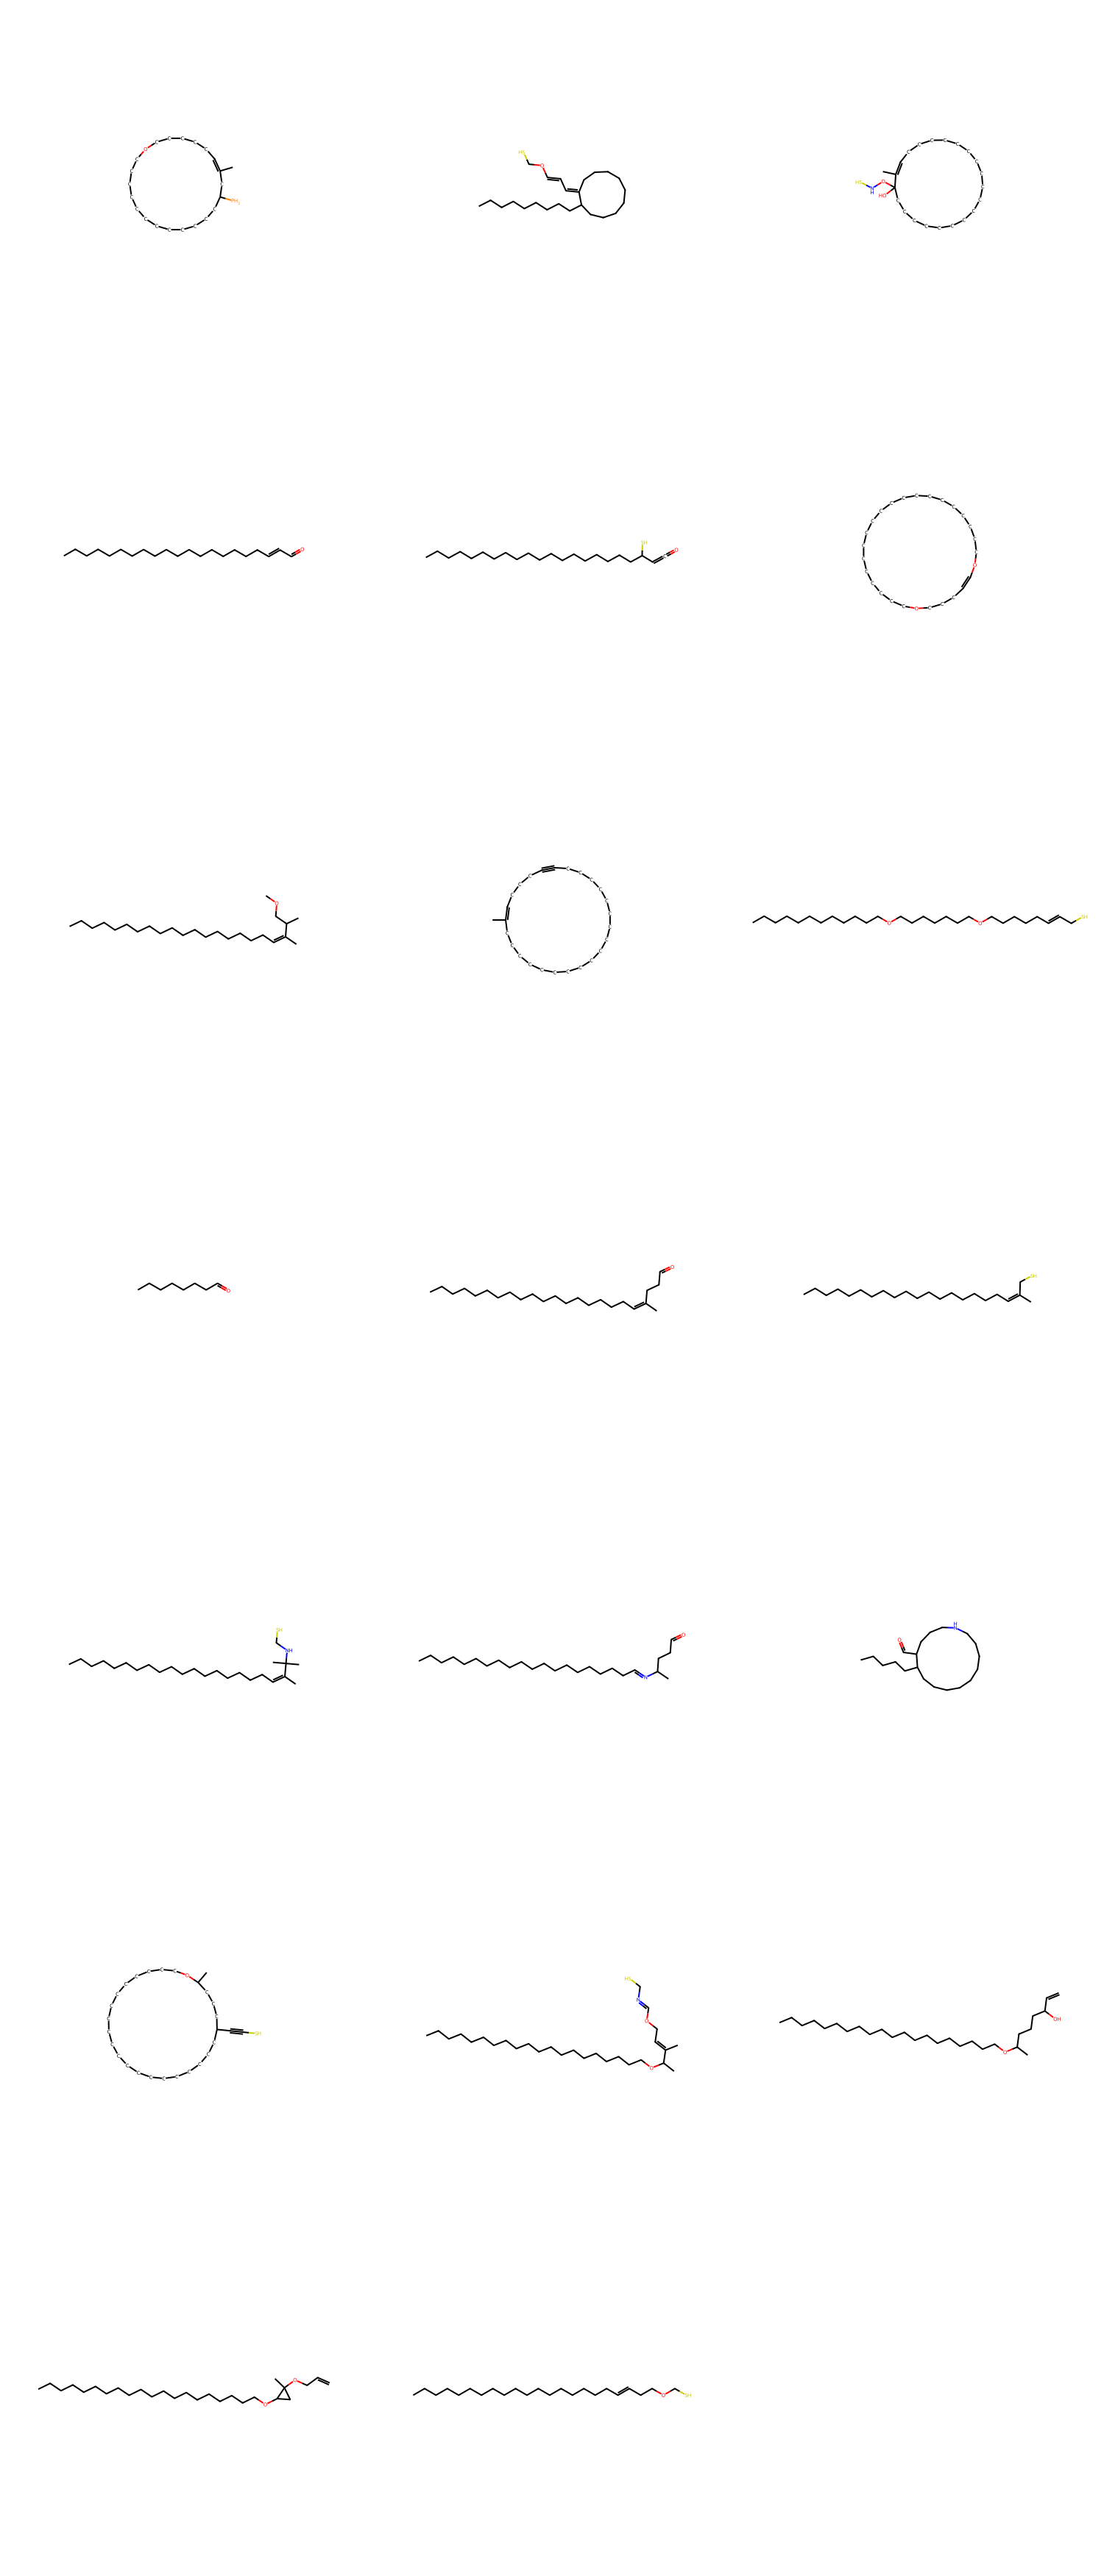

In [89]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

output_mol_list = []
for smiles in output_smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    output_mol_list.append(mol)
img = Draw.MolsToGridImage(output_mol_list, subImgSize=(500, 500))
img